# Семинар 3. Обнаружение траектории энтропийным алгоритмом SPRT

In [2]:
#@title
#%matplotlib
import time                         # библиотека функций системного времени
import numpy as np                  # библиотека математических функций
from scipy.stats import chi2        # библиотека статистических функций
import matplotlib.pyplot as plt     # библиотека построения графиков

T = 50                             # продолжительность траектории
dt = 1                              # шаг дискретизации траектории
time_series = np.arange(1,T,dt)     # отсчеты времени

F = np.array(   [[1.0,  dt],        # матрица перехода текущего состояния в будущее
                [0.0,  1.0]])
G = np.array([dt**2/2, dt])         # матрица связи возмущающего воздействия с вектором состояния объекта

X = np.array([0,10])                # начальное значение вектора состояния объекта

process_noise = 1                   # СКО возмущающего воздействия
np.random.seed(0)                   # выбор случайной последовательности

X_log = {'time':[0], 'state':[X]}   # сохранение данных для отображения
for t in time_series:
    ax = np.random.normal(0,process_noise)
    X = F@X + G*ax
    X_log['time'].append(t)
    X_log['state'].append(X)

x = [X_log['state'][i][0] for i in range(len(X_log['state']))]  # выборка комопненты 'х' ~ [0] из вектора состояния

H = [1, 0]
sigma = 30
z_log = []
for i in range(len(X_log['state'])):
    e = np.random.normal(0, sigma)
    z = H@X_log['state'][i] + e
    z_log.append(z)



## Эллиптическое стробирование

* Целью стробирования является уменьшение числа пар Траектория-Измерение для последующей задачи отождествления измерения и фильтрации.
$$
\begin{equation*}
(z^i_k-\hat{z}^x_{k\mid k-1})^T S^{-1}_{k\mid k-1} (z^i_k-\hat{z}^x_{k\mid k-1}) \lessgtr \gamma_G
\end{equation*}
$$
* где $\gamma_G$ порог стробирования
* при эллиптическом стробировании при совпадении модели измерений и модели движения цели невязка будет распределена по нормальному закону
$$
\begin{equation*}
\Delta{z}_k = z_k - \hat{z}_{k\mid k-1} \sim \mathcal{N} (0,S_{k\mid k-1})
\end{equation*}$$

* Статистика $\Delta{z}_k^T S_{k\mid k-1}^{-1} \Delta{z}$ будет подчинена $\chi^2$ распределению
* Для нахождения порога стробирования надо найти квантиль по заданному уровню вероятности $P_G$ и числу степеней свободы $n$, равному размерности вектора измерений

Для отображения эллиптического строба на плоскотси выполните следующий код

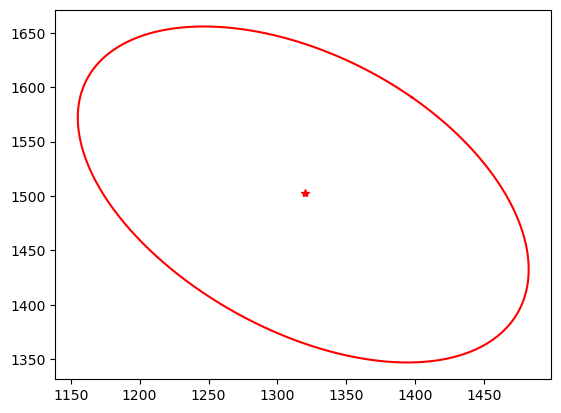

In [3]:
# процедура отображения строба вокруг предсказанного измерения
def plot_strobe(ze,Se, Pg = 0.99):
    plt.plot(ze[0]*np.cos(ze[1]),ze[0]*np.sin(ze[1]),'*r')  # текущее предсказанное измерение
    phi = np.linspace(0,2*np.pi,720)                        # перебор возможных направлений измерений
    cosxy = np.stack((np.cos(phi),np.sin(phi))) # расчет поврота орта
    gamma = chi2.ppf(q = Pg, df = 2)         # расчет границы по уровню вероятности Pg
    U = np.linalg.cholesky(Se)
    gz = np.tile(np.reshape(ze,(-1,1)),(1,720)) # копрование массив для корректного матричного суммирования
    g = gz + np.sqrt(gamma)*U@cosxy        # вычисляем координаты границ строба
    # добавляем пересчет в декартову СК
    x = g[0][0:]*np.cos(g[1][0:])
    y = g[0][0:]*np.sin(g[1][0:])
    plt.plot(x,y,'r')
    
plot_strobe(np.array([2000,0.85]),np.array([[1500,0],[0,1e-3]]),Pg = 0.99) # проверка рисования строба

# Задание №1.

Постройте эллиптические стробы соответствующие вероятности попадания в строб $P_g = 0.5, 0.8, 0.9$.

## Энтропийный (SPRT) алгоритм обнаружения траектории цели
* Основан на вычислении отношения апостериорных вероятностей гипотез $\Lambda_k$ о множестве измерений $z_{0:k}$
* Инициализация траектории в момент $k=0$ должна происходить из выражения
$$ \Lambda_0 = 0 $$
* При попадании очередного измерения в строб траектории увеличить отношения апостериорных вероятностей гипотез $\Lambda_k$
$$\Lambda_k = \Lambda_{k-1} + \ln\left(\frac{P_D\cdot p_{k|k-1}( z_k)}{\beta_{FA}}\right)$$
* $P_D$ - вероятность правильного обнаружения цели в стробе 
* $p_{k|k-1}(y_k) = \mathcal{N}(y_k;\hat{y}_{k\mid k-1}; S_{k\mid k-1})$ вероятность появления измерения при гауссовской модели случайных отсчетов (правдоподобие отсчета)

* При пропуске измерения на очередном такте вторичной обработки скорректикровать $\Lambda_k$
$$ \Lambda_k=\Lambda_{k-1}+\ln(1-P_D P_G)$$
*  $P_G$ - вероятность правильного стробирования, заданная пользователем и использованная для выставления порога $\gamma_G$

* Для принятия решения об обнаружении пользователь должен задать вероятности обнаружения ложной траектории $P_{FC}$ (false confirmation, ложное обнаружение траектории) и вероятности пропуска траектории $P_{TM}$ (track miss, пропуск траектории), а пороги получить из соотношений
$$\gamma_{high} = \ln \frac{1-P_{TM}}{P_{FC}} = \ln \frac{P_{обн.ПТ}}{P_{обн.ЛТ}}$$
$$\gamma_{low} = \ln \frac{P_{TM}}{1-P_{FC}} = \ln \frac{P_{пропуск.ПТ}}{P_{пропуск.ЛТ}}$$
* $\Lambda_k\geq \gamma_{high}$ - траектория обнаружения, верна гипотеза $\mathcal{H}_1$
* $ \Lambda_k\leq \gamma_{low}$ - сброс завязываемой траектории, верна гипотеза $\mathcal{H}_0$ 
* $ \gamma_{low} \leq \Lambda_k\leq \gamma_{high}$ - не достаточно информации о принятии решения, траектория остается на завязке

# Задание   №2

Создайте класс траектории, включающий фильтр траекторных параметров из 2 семинара, процедуру стробирования и отображения строба. 
Подайте на вход объекта траектории измерения из первого семинара и отобразите график изменения. Определите, на каком такте произойдет принятие решения об обнаружении траектории при заданных параметрах $P_{tm} = 0.1, P_{fc} = 0.01, P_D = 0.9, P_G = 0.99, \beta_{FA} = 10^{-6}$. Как надо изменить параметры, чтобы обнаружение произошло раньше.

In [4]:
# напишите ваш код здесь